In [1]:
import nltk
import pandas as pd
import numpy as np
import sklearn

In [2]:
cd C:\Users\varsha chanaliya\Desktop\My_python_programs\Datasets

C:\Users\varsha chanaliya\Desktop\My_python_programs\Datasets


# Loading Data

In [3]:
train_data = pd.read_csv('train_data.csv')
label_data = pd.read_csv('train_label.csv')
test_data = pd.read_csv('test_data.csv')

In [4]:
df = pd.merge(train_data, label_data, on = 'id')
df.drop_duplicates(subset='id', keep='first', inplace=True)
df.head()

,text,id,label
0,"Keep your gloves, hats, coats and jackets toge...",122885,Assembly Required
3,The Home Dynamix Serendipity Ivory 5 ft. 2 in....,188958,Commercial / Residential
7,The Bosch 18-Volt lithium-ion line of Cordless...,146065,Tools Product Type
9,Restore your Porter-Cable sander or polisher t...,165138,Tools Product Type
10,The SPIKECUBE Surge Suppressor from Tripp Lite...,185565,Commercial / Residential


# data Visualization

<Figure size 720x432 with 0 Axes>

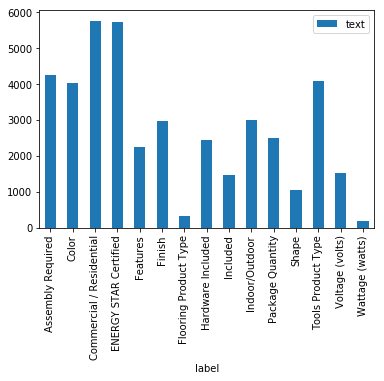

In [149]:
# visualizing label distribution among the data
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
df1 = df[['label','text']]
df1.groupby('label').count().plot.bar(ylim=0)
plt.show()

# Data Preprocessing(featured text,tokenization)

In [36]:
from sklearn.preprocessing import LabelEncoder
y_train = df.label
labels = LabelEncoder()
y_train_labels_fit = labels.fit(y_train)
y_train_labels = labels.transform(y_train)
print(labels.classes_)

['Assembly Required' 'Color' 'Commercial / Residential'
 'ENERGY STAR Certified' 'Features' 'Finish' 'Flooring Product Type'
 'Hardware Included' 'Included' 'Indoor/Outdoor' 'Package Quantity'
 'Shape' 'Tools Product Type' 'Voltage (volts)' 'Wattage (watts)']


numpy.ndarray

In [33]:
text1 = df.text
text2 = test_data.text


In [8]:
# Replace ANY alphanumeric string with spaces, commas, dashes with 'alphanum'
processed_train = text1.str.replace(r'^[a-zA-Z0-9\s.\-]+$', 'alphanum')
processed_test = text1.str.replace(r'^[a-zA-Z0-9\s.\-]+$', 'alphanum')

In [10]:
# Replace all punctuations with ''
processed_train = processed_train.str.replace(r'[^\w\d\s]', '')
processed_test = processed_test.str.replace(r'[^\w\d\s]', '')

In [11]:
# Replace all numerals(with or without decimal or +ve/-ve) with 'num'
processed_train = processed_train.str.replace(r'\d+(\.\d+)?', 'num')
processed_test = processed_test.str.replace(r'\d+(\.\d+)?', 'num')

In [12]:
# Replace whitespace b/w terms with single space
processed_train = processed_train.str.replace(r'\s+',' ')
processed_test = processed_test.str.replace(r'\s+',' ')

In [13]:
# Replace trailing whitespaces
processed_train = processed_train.str.replace(r'^\s+|\s+?$','')
processed_test = processed_test.str.replace(r'^\s+|\s+?$','')

In [14]:
processed_train = processed_train.str.lower()
processed_test = processed_test.str.lower()

In [15]:
#remove stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
processed_train = processed_train.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
processed_test = processed_test.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [16]:
#remove word stem using a porter stemmer

ps = nltk.PorterStemmer()
processed_train = processed_train.apply(lambda x: ' '.join(ps.stem(term)for term in x.split()))
processed_test = processed_test.apply(lambda x: ' '.join(ps.stem(term)for term in x.split()))

# Feature Extraction

In [38]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(processed_train)
tf_transformer = TfidfTransformer().fit(x_train_counts)
x_train_transformed = tf_transformer.transform(x_train_counts)

x_test_counts = count_vect.transform(processed_test)
x_test_transformed = tf_transformer.transform(x_test_counts)


# Training a LinearSVC classifier and using CalibratedClassifierCV to get probabilities for each predicted class

In [39]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

linear_svc = LinearSVC()
clf = linear_svc.fit(x_train_transformed,y_train_labels)

calibrated_svc = CalibratedClassifierCV(base_estimator=linear_svc,
                                        cv="prefit")

calibrated_svc.fit(x_train_transformed,y_train_labels)
predicted = calibrated_svc.predict(x_test_transformed)


In [150]:
out = pd.DataFrame(calibrated_svc.predict_proba(x_test_transformed)*100, columns=labels.classes_)


# Converting output into excel file

In [134]:
out.dropna(how = 'any',inplace = True)
len(out)


10393

In [136]:
out['ID'] = test_data.id

In [139]:
out.set_index('ID',inplace = True)

In [145]:
out.to_csv('sample_submission.csv', encoding='utf-8')

In [148]:
out.shape

(10393, 15)